In [1]:
%matplotlib inline
import pandas as pd

In [2]:
osm_routepoints = pd.read_csv("../data/osm_routepoints.csv", dtype=str)
for c in osm_routepoints.columns:
    new_col = "osm_" + c
    osm_routepoints.rename(columns={c: new_col}, inplace=True)

gtfs_routepoints = pd.read_csv("../data/gtfs_routepoints.csv", dtype=str)
for c in gtfs_routepoints.columns:
    new_col = "gtfs_" + c
    gtfs_routepoints.rename(columns={c: new_col}, inplace=True)

routepoints = gtfs_routepoints.merge(
                    osm_routepoints, how='inner', 
                    right_on=["osm_osm:ref:FR:STIF", "osm_osm:ref:FR:STIF:ExternalCode_Line"],
                    left_on=["gtfs_ZDEr_ID_REF_A", "gtfs_route_id"]
               )
len(routepoints)

13019

In [3]:
routepoints_strict = routepoints[routepoints["osm_name"] == routepoints["gtfs_stop_name"]]
routepoints_strict = routepoints_strict[routepoints_strict["osm_destination"] == routepoints_strict["gtfs_dest_name"]]

len(routepoints_strict)

97

In [4]:
routepoints_strict.head()

,gtfs_stop_id,gtfs_route_id,gtfs_ZDEr_ID_REF_A,gtfs_stop_name,gtfs_stop_lat,gtfs_stop_lon,gtfs_wheelchair_boarding,gtfs_dest_name,gtfs_route_short_name,gtfs_agency_name,osm_stop_id,osm_name,osm_code,osm_destination,osm_network,osm_osm:ref:FR:STIF,osm_osm:ref:FR:STIF:ExternalCode_Line,osm_lat,osm_lon
685,StopPoint:35:1146,040240004:4,21408,Les Monrois,48.774157,2.52938,NaN,Gare RER Sucy-Bonneuil,4,SITUS,StopPoint:Node:3140222572,Les Monrois,4,Gare RER Sucy-Bonneuil,SITUS,21408,040240004:4,48.7740601,2.5293818
691,StopPoint:35:1148,040240004:4,21410,Moulin de Touillon,48.776507,2.526533,NaN,Gare RER Sucy-Bonneuil,4,SITUS,StopPoint:Node:3140222569,Moulin de Touillon,4,Gare RER Sucy-Bonneuil,SITUS,21410,040240004:4,48.7765115,2.526554
2448,StopPoint:40:100,059440038:38,8938,Les Grouettes,49.031674,2.069058,NaN,Préfecture RER,38,STIVO,StopPoint:Node:1866033587,Les Grouettes,38,Préfecture RER,STIVO,8938,059440038:38,49.031708699999996,2.0689295
2449,StopPoint:40:100,059440038:38,8938,Les Grouettes,49.031674,2.069058,NaN,Préfecture RER,38,STIVO,StopPoint:Node:1866033587,Les Grouettes,38,Préfecture RER,STIVO,8938,059440038:38,49.031708699999996,2.0689295
2456,StopPoint:40:13,059440038:38,10137,Conseil Départemental,49.03192,2.075043,1,Préfecture RER,38,STIVO,StopPoint:Node:617854915,Conseil Départemental,38,Préfecture RER,STIVO,10137,059440038:38,49.0318974,2.0750553


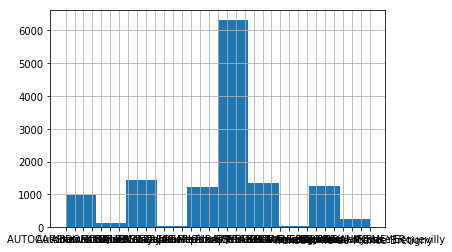

In [5]:
routepoints['gtfs_agency_name'].hist()

#todo : lire la doc de matplotlib pour faire un graphe où on voit les légendes

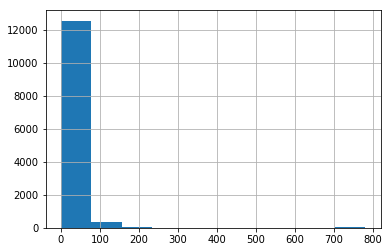

In [6]:
from geopy.distance import vincenty

def compute_distance(row):
    dist = vincenty(
        (float(row['osm_lat']), float(row['osm_lon'])), 
        (float(row['gtfs_stop_lat']), float(row['gtfs_stop_lon']))
    )
    return dist.meters
   
routepoints['distance'] = routepoints.apply(compute_distance, axis=1)

routepoints['distance'].hist()

In [7]:
len(routepoints[routepoints['distance'] > 50])

1025

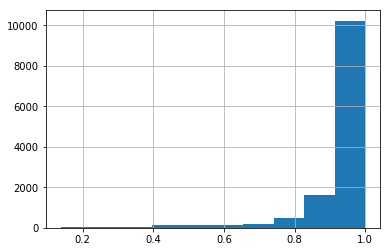

In [8]:
import difflib

difflib.SequenceMatcher(None, 'Gare de Laplace (Arcueil)', 'Arcueil Laplace RER').ratio() # 0.5
difflib.SequenceMatcher(None, 'Sucy-Bonneuil RER', 'Gare de Sucy-Bonneuil').ratio() # 0.68
difflib.SequenceMatcher(None, 'Noisy-le-Roi - Centre Commercial le Cèdre', 'Centre commercial').ratio() #0.55
difflib.SequenceMatcher(None, 'Cimetière', 'Cimetière de Saint-Maur-des-Fossés').ratio() #0.41
difflib.SequenceMatcher(None, 'A. Lebrun', 'Auguste Lebrun').ratio() #0.69
difflib.SequenceMatcher(None, 'Saint-Maur Créteil', 'SAINT-MAUR - CRETEIL RER').ratio() #0.23
difflib.SequenceMatcher(None, 'Saint-Maur Créteil'.lower(), 'SAINT-MAUR - CRETEIL RER'.lower()).ratio() #0.80

def compute_similarity(elem1, elem2):
    return difflib.SequenceMatcher(None, elem1.lower(), elem2.lower()).ratio()

routepoints['name_confidence'] = routepoints[['osm_name','gtfs_stop_name']].apply(lambda x: compute_similarity(*x), axis=1)
routepoints['name_confidence'].hist()

In [9]:
len(routepoints[routepoints['name_confidence'] > 0.6])

12559

12547

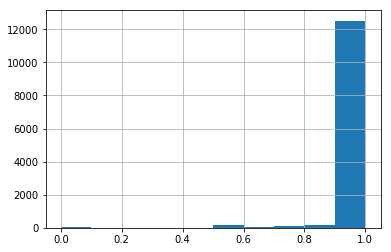

In [10]:
routepoints['line_code_confidence'] = routepoints[['osm_code','gtfs_route_short_name']].apply(lambda x: compute_similarity(*x), axis=1)
routepoints['line_code_confidence'].hist()
len(routepoints[routepoints['line_code_confidence'] > 0.8])

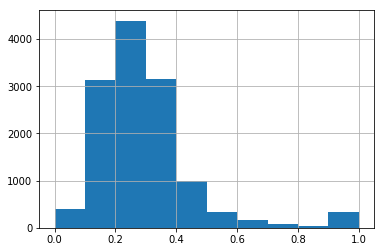

In [11]:
routepoints['destination_confidence'] = routepoints[['osm_destination','gtfs_dest_name']].apply(lambda x: compute_similarity(*x), axis=1)
routepoints['destination_confidence'].hist()

In [12]:
len(routepoints[routepoints['destination_confidence'] > 0.6])
#TODO : à vérifier !!

609

In [13]:
#tt = routepoints[routepoints['destination_confidence'] < 0.5]
#tt.to_csv('to_investigate_dest.csv')

#tt = routepoints[routepoints['name_confidence'] < 0.5]
#tt.to_csv('to_investigate_name.csv')

#tt = routepoints[routepoints['line_code_confidence'] < 0.5]
#tt.to_csv('to_investigate_line.csv')

In [14]:
import folium
map_ = folium.Map(location=[48.8527, 2.3387])
for index, row in routepoints_strict.head().iterrows():
    folium.Marker([float(row['gtfs_stop_lat']), float(row['gtfs_stop_lon'])], popup=row['gtfs_stop_name']).add_to(map_)

map_